In [12]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
# Open tensorboard in cmd
command = 'tensorboard --logdir=Tensorflow/workspace/training_demo/models/my_ssd_resnet50_v1_fpn'

In [3]:
# Variables
training_dataset_name = 'training_demo'
new_model_name = 'my_ssd_resnet50_v1_fpn'

PIPELINE_CONFIG_PATH = os.path.join('Tensorflow', 'workspace', training_dataset_name, 'models', new_model_name, 'pipeline.config')
CHECKPOINT_PATH = os.path.join('Tensorflow', 'workspace', training_dataset_name, 'models', new_model_name)
LABEL_MAP_PATH = os.path.join('Tensorflow', 'workspace', training_dataset_name, 'annotations', 'label_map.pbtxt')

In [4]:
# Import model configuration
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)
model_config = configs['model']

# Build model 
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Set up the checkpoint
checkpoint = 'ckpt-4'
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, checkpoint)).expect_partial()

In [5]:
# Define a function to detect from image
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [6]:
# Load label map data
category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH,
                                                                    use_display_name=True)

In [8]:
# Run webcam check
import cv2
import numpy as np

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (width, height)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

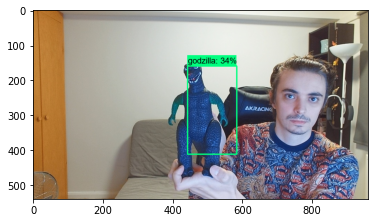

In [16]:
# Run image check
IMAGE_PATH = os.path.join('Tensorflow', 'workspace', training_dataset_name, 'images', 'test', 'godzilla.14c62979-20ac-11ec-97ab-44af28a42ad0.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.3,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()